In [23]:
import yt
yt.funcs.mylog.setLevel(40) # Surpresses YT status output.
import numpy as np
import matplotlib.pyplot as plt
import glob

In [58]:
file_path = './M4V02_rm7/turbsph_hdf5_plt_cnt_0225'

ds = yt.load(file_path) # loads in data into data set class. This is what we will use to plot field values
ad = ds.all_data() # Can call on the data set's property .all_data() to make an object 
                   # containing all data available to be parsed through.
                   # print ad['mass'] will print the list of all cell masses. print ad.mass().max()


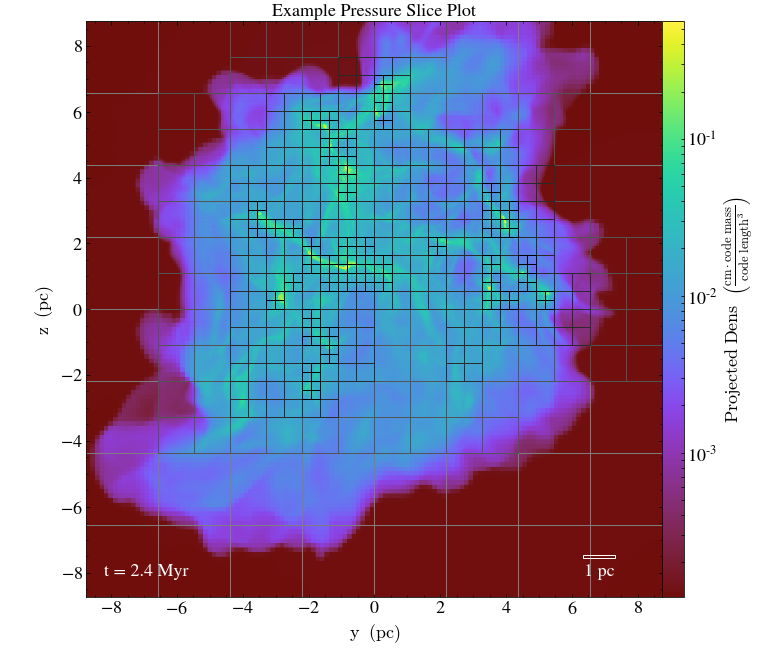

In [74]:
field ='dens'
ax = 'x'
plot_ = yt.ProjectionPlot(ds, ax, field)
plot_.annotate_timestamp()
plot_.annotate_grids()
#plot_.zoom(4)
#plot_.annotate_velocity()
#plot_.set_zlim('dens', 1.0e-3, 1.0e-1)
plot_.annotate_title('Example Pressure Slice Plot')
plot_.annotate_scale()
plot_.show()

In [75]:
for i, typ in enumerate(ad['particle_type']):
    if typ == 2.0:
        print ad['particle_position'][i]#.to('Msun').value
        print i

[ -1.29060941e+18  -2.39755837e+18   3.94874797e+18] code_length
251
[ -1.25223028e+18  -2.44797682e+18   3.93798390e+18] code_length
252
[ -1.32579614e+18  -2.47714145e+18   3.93505742e+18] code_length
253
[ -1.55517776e+18  -2.39776467e+18   4.22668565e+18] code_length
316
[ -2.49973610e+18  -4.07836750e+18   1.53763279e+19] code_length
371
[ -2.82113904e+18  -4.64700586e+18   1.71960255e+19] code_length
373
[  4.76685059e+17  -6.02267627e+18   5.24451946e+18] code_length
379
[  5.37578558e+18  -1.07476215e+19   8.87055845e+18] code_length
420
[ -6.86303222e+18   1.08504985e+19   1.90243921e+18] code_length
471
[ -6.90910916e+18   1.09651348e+19   1.92692519e+18] code_length
472
[ -4.28151654e+18   1.23260599e+19   8.21625941e+18] code_length
519
[ -4.27130074e+18   1.22077269e+19   8.53804496e+18] code_length
565
[ -4.87688837e+18   1.06538776e+19   1.01689270e+19] code_length
591
[ -8.48421425e+18   1.39594106e+19   3.38812449e+18] code_length
600
[ -4.56781397e+17   1.26703114e+17

How to find the mass of each cell within a sink?
* The easiest way to do this would be to have the data be written out to the `sinks_evol.dat` file but this may require a bit of work since I would have to transport data of looped over blocks within sink. An exercise worth doing,=.
* with yt plotting, I have the info of where the sink particle is as well as its radius. With this, I can create a spherical data object that reads the internal mass. The data-object can be set to the sink's position so it remains followed if plt files are looped over. Can I get sinktag data here?? Yeeea baby, with `ad['particle_tag']`. Oh shit, and `ad['particle_blk']` (same as `ad['particle_index']`) is available too.
* also have `ad['gas', 'sound_speed']`, `ad['gas', 'kT']`
`ad[mesh_id]` corresponds to the cell id that the particle is in??

https://yt-project.org/doc/analyzing/filtering.html

In [46]:
print ds.derived_field_list

[('all', 'mesh_id'), ('all', u'particle_accr_rate'), ('all', u'particle_accx'), ('all', u'particle_accy'), ('all', u'particle_accz'), ('all', 'particle_angular_momentum'), ('all', 'particle_angular_momentum_magnitude'), ('all', 'particle_angular_momentum_x'), ('all', 'particle_angular_momentum_y'), ('all', 'particle_angular_momentum_z'), ('all', u'particle_bgdy'), ('all', u'particle_blk'), ('all', u'particle_creation_time'), ('all', u'particle_csgm'), ('all', 'particle_cylindrical_velocity_theta'), ('all', 'particle_cylindrical_velocity_z'), ('all', u'particle_dmdt'), ('all', u'particle_dtold'), ('all', u'particle_eion'), ('all', u'particle_epep'), ('all', u'particle_gpot'), ('all', 'particle_index'), ('all', u'particle_kine'), ('all', 'particle_mass'), ('all', u'particle_nion'), ('all', u'particle_npep'), ('all', u'particle_oacx'), ('all', u'particle_oacy'), ('all', u'particle_oacz'), ('all', u'particle_old_pmass'), ('all', 'particle_ones'), ('all', 'particle_position'), ('all', 'part

In [47]:
print ad['particle_radius']
print ad['particle_velocity_magnitude'].to('km/s').value.max()
print ad['gas', 'sound_speed'].to('km/s').value.max()


[  1.21895399e+19   1.30910111e+19] cm
0.51674636128
8.06129166006


In [82]:
center = ad['particle_position'][470].v
print ad['particle_position'][470].v

radius = (1.318344e17, 'cm')
ds2 = yt.load('./M4V02_rm7/turbsph_hdf5_plt_cnt_0225')

sph = ds2.sphere(center, radius)
#sp = ds.sphere([0.5, 0.5, 0.5], (1, 'kpc'))
print "The mean gas sound speed inside the sink is: ", (sph['gas','sound_speed']).mean()

cell_vol = sph['dx'].min().v ** 3
cell_masses = []
for den in sph['dens'].v:
    mass = den * cell_vol
    cell_masses.append(mass)
total_mass = sum(cell_masses) # in grams
print "total mass: ", total_mass
G = 6.67e-8
virial_v = np.sqrt((3./5) * G * total_mass / radius[0])

print "maximum cell density is: ", sph['dens'].v.max()

print "Virial velocity of sink (km/s) is: ", virial_v*1e-5
print "Virial velocity is this nuber of times greater than gas soundspeed: ", virial_v*1e-5 / (sph['gas','sound_speed']).to("km/s").mean().v

[ -6.87095934e+18   1.09233510e+19   1.87732731e+18]
The mean gas sound speed inside the sink is:  37414.3468286 cm/s
total mass:  3.66738788932e+33
maximum cell density is:  1.46345310961e-18
Virial velocity of sink (km/s) is:  0.333658806436
Virial velocity is this nuber of times greater than gas soundspeed:  0.891793749505


In [57]:
#Energy budget of gas within sink
print sph['kinetic_energy'][0]
kinetic_energy = 0.5*sph["gas", "velocity_magnitude"]**2
print kinetic_energy[0]
print sph['thermal_energy'][0]
print sph['total_energy'][0]
print sph['gpot'][0]
print (sph['thermal_energy'] + kinetic_energy / sph['total_energy']).mean()


6.27517970685e-10 dyne/cm**2
1727498924.23 cm**2/s**2
1252000384.0 erg/g
2979499264.0 erg/g
-93953753088.0 code_length**2/code_time**2


YTUnitOperationError: The addition operator for YTArrays with units (erg/g) and (cm**2*g/(erg*s**2)) is not well defined.

In [11]:
#print sph['particle_tag']
#print("(x,  y,  z)                       Temperature(K)          cs(km/s)")
#print("-----------------------")
#for i in range(sph["temperature"].size):
#    print("(%f,  %f,  %f)    %f     %f" %
#          (sph["x"][i].to('pc'), 
#           sph["y"][i].to('pc'), 
#           sph["z"][i].to('pc'), 
#           sph["temperature"][i], 
#           sph["sound_speed"][i].v))


In [22]:
m_star = 1e33
v_vir = 4e5
a = 1.5*1.318344e17
KE = 0.5*m_star*v_vir**2
PE = G*m_star*m_star / a
Etot = KE - PE
print Etot
print KE/PE

7.96627081652e+43
237.183328336


In [31]:
data_files = glob.glob('./M4V02_rm7/turbsph_hdf5_plt_cnt_01*')
print data_files
for file_ in data_files:
    ds = yt.load(file_)
    ad = ds.all_data()
    for i, particle_type in enumerate(ad['particle_type']):
        if particle_type == 2.0:
            print i
    print ad['particle_type']

['./M4V02_rm7/turbsph_hdf5_plt_cnt_0189', './M4V02_rm7/turbsph_hdf5_plt_cnt_0108', './M4V02_rm7/turbsph_hdf5_plt_cnt_0109']
20
21
183
203
213
239
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  2.  2.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  2.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  2.  1.  1.  1.  1.  1.  1.  1

YTFieldNotFound: Could not find field '('io', 'particle_type')' in turbsph_hdf5_plt_cnt_0108.

# Trying again, something slimmer
can we isolate the sink data in a nice way? Let's try:

https://yt-project.org/doc/analyzing/filtering.html

In [87]:
ds3 = yt.load('./M4V02_rm7/turbsph_hdf5_plt_cnt_0225')
ad3 = ds3.all_data()
sinks = ad3['particle_type'] > 1.0
print ad3['particle_velocity_magnitude'][sinks]

[ 380931.72870103  402879.49756774  125995.26938226  309053.97644369
   86462.82235111   73755.01042314  185533.6801459    78756.73518371
   75166.32112475  204545.26926649  134679.53073886   78433.80506441
   72009.53237681  126361.4413383   133830.81420414  111505.13572295
   83100.49075862] cm/s
